In [1]:
import sys
sys.path.append('generate_data')
from generator import *
import pandas as pd
import json

<h4>The task involves developing a data pipeline to complete the user story above using sample data
sources that will be provided.<br><br>
Our data science team has reached out to our data engineering team requesting we pre-process
some of the data for them at scale so that they can make better use of it in their downstream
algorithms.<br><br>
The input data sources are comprised of customers (in CSV format), transactions (in JSON Lines
format) and products (in CSV format). Their details are presented below</h4>

### Loading data

##### Customers

In [2]:
df_customers_loyalty = read_csv(os.path.join(output_location, 'customers.csv'))
df_customers_loyalty.head()

,customer_id,loyalty_score
0,C1,7
1,C2,4
2,C3,13
3,C4,11
4,C5,8


##### Products

In [3]:
df_products_category = read_csv(os.path.join(output_location, 'products.csv'))
df_products_category.head()

,product_id,product_description,product_category
0,P01,detergent,house
1,P02,kitchen roll,house
2,P03,bin liners,house
3,P04,shower gel,house
4,P05,scented candles,house


##### Transactions

In [4]:
df_transactions = read_json_folder(os.path.join(output_location, 'transactions',''))
df_transactions.head()

,customer_id,basket,date_of_purchase
0,C5,"[{'product_id': 'P56', 'price': 566}]",2023-01-29 11:07:42.437257
1,C7,"[{'product_id': 'P12', 'price': 1274}]",2023-01-28 21:25:42.437257
2,C8,"[{'product_id': 'P28', 'price': 494}, {'produc...",2023-01-29 05:34:42.437257
3,C10,"[{'product_id': 'P31', 'price': 17}, {'product...",2023-01-29 00:39:42.437257
4,C12,"[{'product_id': 'P11', 'price': 795}]",2023-01-29 01:35:42.437257


In [5]:
json_string = df_transactions.to_json(orient='records')

data_dict = json.loads(json_string)

df_customers_transactions = pd.json_normalize(data_dict, record_path='basket', meta=['customer_id', 'date_of_purchase'])
df_customers_transactions

,product_id,price,customer_id,date_of_purchase
0,P56,566,C5,2023-01-29 11:07:42.437257
1,P12,1274,C7,2023-01-28 21:25:42.437257
2,P28,494,C8,2023-01-29 05:34:42.437257
3,P28,16,C8,2023-01-29 05:34:42.437257
4,P31,17,C10,2023-01-29 00:39:42.437257
...,...,...,...,...
4303,P35,1770,C135,2023-04-28 18:40:42.437257
4304,P37,1110,C135,2023-04-28 18:40:42.437257
4305,P27,802,C137,2023-04-28 18:37:42.437257
4306,P34,1863,C137,2023-04-28 18:37:42.437257


### Task from Data Analyst

As a data scientist I want to be able to consume a data source that
contains information about customer's baskets: 
- at job days and weekend;
- quantity of products, and unique set of products;
- price statistics: min, max, average, median;


The output data source should contain information for every customer that has the following
fields:

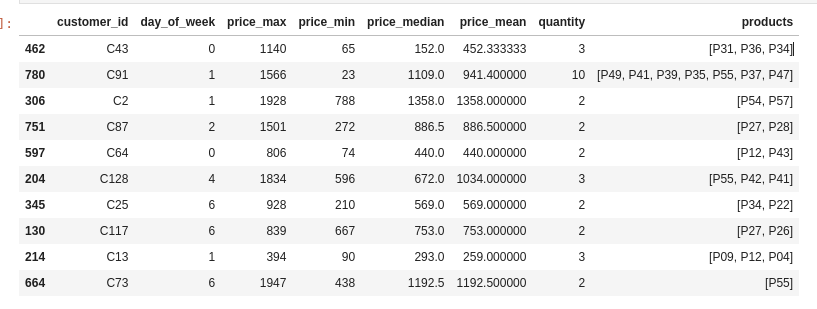

In [6]:
df_customers_transactions['date_of_purchase'] = pd.to_datetime(df_customers_transactions['date_of_purchase'])

df_customers_transactions['day_of_week'] = df_customers_transactions['date_of_purchase'].dt.weekday
df_customers_transactions


,product_id,price,customer_id,date_of_purchase,day_of_week
0,P56,566,C5,2023-01-29 11:07:42.437257,6
1,P12,1274,C7,2023-01-28 21:25:42.437257,5
2,P28,494,C8,2023-01-29 05:34:42.437257,6
3,P28,16,C8,2023-01-29 05:34:42.437257,6
4,P31,17,C10,2023-01-29 00:39:42.437257,6
...,...,...,...,...,...
4303,P35,1770,C135,2023-04-28 18:40:42.437257,4
4304,P37,1110,C135,2023-04-28 18:40:42.437257,4
4305,P27,802,C137,2023-04-28 18:37:42.437257,4
4306,P34,1863,C137,2023-04-28 18:37:42.437257,4


In [7]:
customer_activity = pd.merge(df_products_category, df_customers_transactions, on='product_id', how='left')
customer_activity

,product_id,product_description,product_category,price,customer_id,date_of_purchase,day_of_week
0,P01,detergent,house,74,C23,2023-01-28 16:02:42.437257,5
1,P01,detergent,house,187,C67,2023-01-31 01:09:42.437257,1
2,P01,detergent,house,610,C22,2023-02-02 20:31:42.437257,3
3,P01,detergent,house,1873,C118,2023-02-04 06:29:42.437257,5
4,P01,detergent,house,612,C132,2023-02-03 15:55:42.437257,4
...,...,...,...,...,...,...,...
4303,P64,cigarettes,bws,275,C127,2023-04-24 06:39:42.437257,0
4304,P64,cigarettes,bws,127,C127,2023-04-24 06:39:42.437257,0
4305,P64,cigarettes,bws,1427,C15,2023-04-25 07:35:42.437257,1
4306,P64,cigarettes,bws,1985,C37,2023-04-26 02:37:42.437257,2


In [8]:
result_df = pd.merge(df_customers_loyalty, customer_activity, on='customer_id')
result_df

,customer_id,loyalty_score,product_id,product_description,product_category,price,date_of_purchase,day_of_week
0,C1,7,P42,chicken,food,1155,2023-02-10 09:19:42.437257,4
1,C1,7,P42,chicken,food,59,2023-02-14 18:36:42.437257,1
2,C1,7,P42,chicken,food,522,2023-03-09 04:33:42.437257,3
3,C1,7,P42,chicken,food,1117,2023-03-12 12:35:42.437257,6
4,C1,7,P44,milk,food,21,2023-02-10 09:19:42.437257,4
...,...,...,...,...,...,...,...,...
4303,C137,5,P33,apples,fruit_veg,684,2023-03-04 22:30:42.437257,5
4304,C137,5,P33,apples,fruit_veg,971,2023-03-23 16:35:42.437257,3
4305,C137,5,P34,raspberries,fruit_veg,1826,2023-03-03 08:07:42.437257,4
4306,C137,5,P34,raspberries,fruit_veg,1863,2023-04-28 18:37:42.437257,4


In [9]:
cust_info = result_df.groupby(['customer_id', 'day_of_week']).agg(
    price_max=('price', 'max'),
    price_min=('price', 'min'),
    price_median=('price', 'median'),
    price_mean=('price', 'mean'),
    quantity=('product_id', 'count')
)
cust_info

price_max  price_min  price_median   price_mean   
customer_id day_of_week                                                    
C1          0                 1334        564        1204.0  1034.000000  \
            1                 1894         59         912.0   878.666667   
            3                 1056        522         766.0   777.500000   
            4                 1821         21        1098.0   937.200000   
            5                 1320        139         539.0   666.000000   
...                            ...        ...           ...          ...   
C98         6                 1979        382        1240.0  1156.600000   
C99         1                  325        325         325.0   325.000000   
            2                 1496         38         517.0   704.000000   
            3                 1800        215        1007.5  1007.500000   
            6                 1925         86        1915.0  1308.666667   

                         quantity  
customer_id day_of_week            
C1          0                   3  
            1                   6  
            3                   4  
            4                   5  
            5                   3  
...                           ...  
C98         6                   5  
C99         1                   1  
            2                   6  
            3                   2  
            6                   3  

[805 rows x 5 columns]

In [10]:
products_agg = result_df.groupby(['customer_id', 'day_of_week'])['product_id'].agg(lambda x: ','.join(x)).reset_index()
products_agg

,customer_id,day_of_week,product_id
0,C1,0,"P47,P51,P55"
1,C1,1,"P42,P45,P48,P49,P54,P60"
2,C1,3,"P42,P48,P54,P58"
3,C1,4,"P42,P44,P54,P57,P60"
4,C1,5,"P48,P54,P55"
...,...,...,...
800,C98,6,"P62,P62,P62,P63,P64"
801,C99,1,P40
802,C99,2,"P05,P06,P06,P24,P25,P25"
803,C99,3,"P31,P34"


In [11]:
table_for_ds = pd.merge(cust_info, products_agg, on=['customer_id', 'day_of_week'], how='left')
table_for_ds = table_for_ds.rename(columns={'product_id': 'products'})
table_for_ds

,customer_id,day_of_week,price_max,price_min,price_median,price_mean,quantity,products
0,C1,0,1334,564,1204.0,1034.000000,3,"P47,P51,P55"
1,C1,1,1894,59,912.0,878.666667,6,"P42,P45,P48,P49,P54,P60"
2,C1,3,1056,522,766.0,777.500000,4,"P42,P48,P54,P58"
3,C1,4,1821,21,1098.0,937.200000,5,"P42,P44,P54,P57,P60"
4,C1,5,1320,139,539.0,666.000000,3,"P48,P54,P55"
...,...,...,...,...,...,...,...,...
800,C98,6,1979,382,1240.0,1156.600000,5,"P62,P62,P62,P63,P64"
801,C99,1,325,325,325.0,325.000000,1,P40
802,C99,2,1496,38,517.0,704.000000,6,"P05,P06,P06,P24,P25,P25"
803,C99,3,1800,215,1007.5,1007.500000,2,"P31,P34"
